In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
import NaiveDE
import SpatialDE

raw data dim: (237, 15284)
Rep9_processing: (234, 14109)


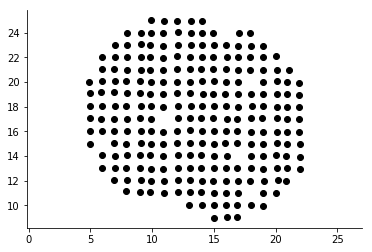

(276,)
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep9_result_df.csv
(327, 241)
(142, 19)
raw data dim: (281, 16416)
Rep10_processing: (278, 14764)


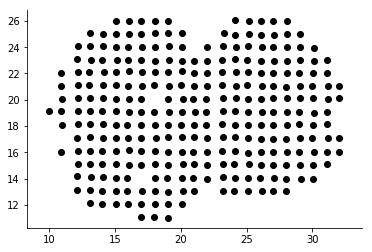

(1078,)
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep10_result_df.csv
(1330, 285)
(607, 19)
raw data dim: (262, 16218)
Rep11_processing: (259, 14639)


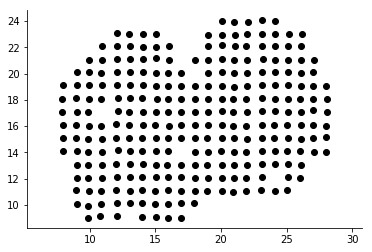

(421,)
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep11_result_df.csv
(751, 266)
(67, 19)


In [9]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from main_methods import select_spatial_genes
from matplotlib_venn import venn2,venn3

def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
    
def load_replicate_result(j):
    # load the data for a given replicate
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    ff = ddir + '/data/Raw_data/MOB-breast-cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
    locs,data=read_spatial_expression(ff,sep='\t')
    data_norm = normalize_count_cellranger(data)
    print('Rep{}_processing: {}'.format(j,data_norm.shape))
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.scatter(*locs.T, c='k')
    plt.axis('equal')
    plt.show()
    alpha= 0.01
    # run our method
    pvals, rej_idx = select_spatial_genes(locs, data_norm.values, alpha=alpha, n_perm=100000)
    ours = data_norm.columns[rej_idx]
    print(ours.shape)

    # load scgco result
    fn = ddir+'/data/MouseOB/scGCO_results/Rep'+ str(j)+'_result_df.csv'
    print(fn)
    gco_df = pd.read_csv(fn, index_col=0)
    gco_df = gco_df.loc[gco_df['fdr'] < alpha]
    print(gco_df.shape)

    # load spatial de result
    de_df=pd.read_csv(ddir+'/data/MouseOB/spatialDE_results/Rep'+ str(j)+'_MOB_results.csv')
    de_df=de_df[de_df.qval<0.05]
    de_df=de_df.query("g!='log_total_count'")
    print(de_df.shape)
    
    return {
        'scGCO': set(gco_df.index),
        'SpatialDE': set(de_df.g.values),
        'Ours': set(ours)
    }
res = {}
for v in [9, 10, 11]:
    res[v] = load_replicate_result(v)

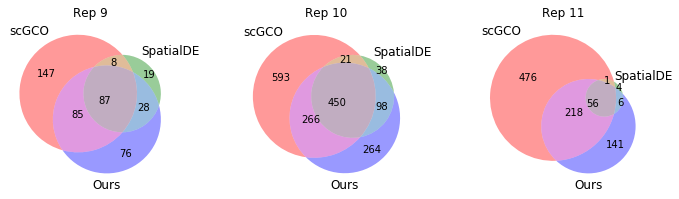

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
for i, val in enumerate(res.keys()):
    ax = axes[i]
    plot_venn3(res[val], ax)
    ax.set_title('Rep {}'.format(val))
plt.show()

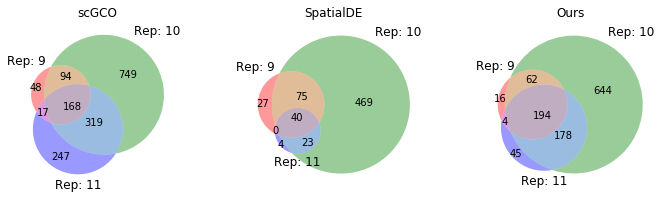

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
for  i, m in enumerate(['scGCO', 'SpatialDE', 'Ours']):
    dd = {'Rep: {}'.format(k): res[k][m] for k in res}
    ax = axes[i]
    plot_venn3(dd, ax)
    ax.set_title(m)
plt.show()

In [6]:
norm_expr = NaiveDE.stabilize(counts.T).T
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_counts)').T

In [7]:
sample_resid_expr = resid_expr.sample(n=1000, axis=1, random_state=1)

In [10]:
sample_resid_expr.shape

(260, 1000)

In [11]:
X = sample_info[['x', 'y']]
results = SpatialDE.run(X, sample_resid_expr)

[root INFO] Performing DE test
[root INFO] Pre-calculating USU^T = K's ...
[root INFO] Done: 0.13s
[root INFO] Fitting gene models


HBox(children=(IntProgress(value=0, description='Models: ', max=10, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

[root INFO] Finished fitting 10 models to 1000 genes


In [12]:
results.head().T

,0,1,2,3,4
FSV,2.0597e-09,0.694631,2.0597e-09,2.0597e-09,2.0597e-09
M,4,4,4,4,4
g,Ccdc68,Sh3bp5,Sds,Ccndbp1,Large
l,0.402001,0.402001,0.402001,0.402001,0.402001
max_delta,4.85165e+08,0.439304,4.85165e+08,4.85165e+08,4.85165e+08
max_ll,629.916,-0.484268,326.015,-106.303,-93.2679
max_mu_hat,0.883036,-0.523775,0.913722,-2.86805,-3.55459
max_s2_t_hat,1.60814e-09,0.210215,1.73066e-09,1.72278e-08,2.62902e-08
model,SE,SE,SE,SE,SE
n,260,260,260,260,260


In [13]:
results.sort_values('qval').head(10)[['g', 'l', 'qval']]

,g,l,qval
803,Nrsn1,1.907609,0.002607
769,Pcp4,1.135190,0.016558
876,Ncdn,1.907609,0.073741
868,Ctxn1,1.907609,0.085747
789,Dnajc6,1.135190,0.085747
850,Egr1,1.907609,0.109079
827,Syn1,1.907609,0.140688
677,Kcnj10,0.675535,0.140688
583,Rcn2,0.675535,0.140688
675,6330403K07Rik,0.675535,0.248970


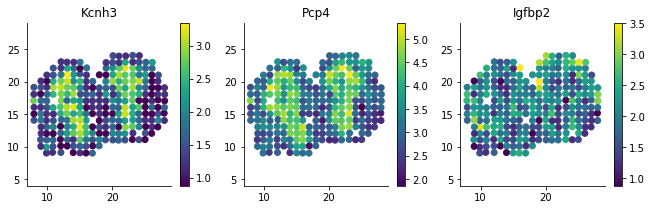

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
for i, g in enumerate(['Kcnh3', 'Pcp4', 'Igfbp2']):
    ax = axes[i]
    im = ax.scatter(sample_info['x'], sample_info['y'], c=norm_expr[g]);
    ax.set_title(g)
    ax.axis('equal')
    fig.colorbar(im, ax=ax);
plt.show()

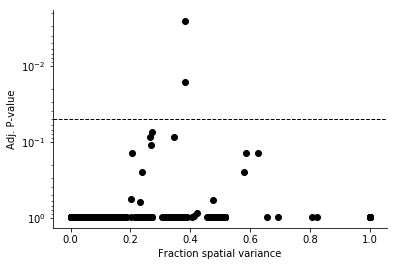

In [33]:
plt.yscale('log')

plt.scatter(results['FSV'], results['qval'], c='black')

plt.axhline(0.05, c='black', lw=1, ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value');

In [34]:
sign_results = results.query('qval < 0.5')
sign_results['l'].value_counts()
histology_results, patterns = SpatialDE.aeh.spatial_patterns(X, resid_expr, sign_results, C=3, l=1.8, verbosity=1)

iter 0, ELBO: -9.21e+08
iter 1, ELBO: -4.20e+08, delta_ELBO: 5.01e+08
iter 2, ELBO: -4.20e+08, delta_ELBO: 4.53e+02
iter 3, ELBO: -4.20e+08, delta_ELBO: 2.89e+02
iter 4, ELBO: -4.20e+08, delta_ELBO: 1.23e+01
iter 5, ELBO: -4.20e+08, delta_ELBO: 4.54e-01
iter 6, ELBO: -4.20e+08, delta_ELBO: 1.68e-02
iter 7, ELBO: -4.20e+08, delta_ELBO: 6.20e-04
Converged on iter 7


In [35]:
histology_results.head()

,g,pattern,membership
583,Rcn2,0,1.0
675,6330403K07Rik,1,1.0
677,Kcnj10,0,1.0
757,Meis2,2,1.0
769,Pcp4,2,1.0


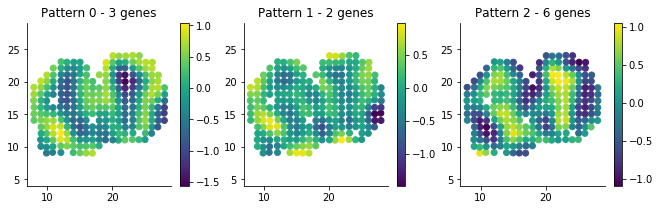

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
for i in range(3):
    ax = axes[i]
    im = ax.scatter(sample_info['x'], sample_info['y'], c=patterns[i]);
    ax.axis('equal')
    ax.set_title('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0] ))
    fig.colorbar(im, ax=ax);
plt.show()